# Stage 0: SETUP
The following libraries are used directly. For the full list of installed packages and versions, please see requirements.txt

In [1]:
# Imports
import pandas as pd
import numpy as np

# Stage 1: DATA ACQUISITION

Data is downloaded as csv files, and is already available in this repository in the data folder. See the readme for details on the source of the data.

## Case Data
Case data is provided with dates as columns. For processing, the data is melted into a "date" column and "case_count" column, and unused columns are dropped.

In [2]:
# Get raw data, only keep used columns
raw_case_data = pd.read_csv('data/raw/RAW_us_confirmed_cases.csv').drop(columns = ["Province_State", "Admin2", "UID", "iso2", "iso3", "Country_Region", "Lat", "Long_", "code3", "Combined_Key"])


# Pivot into dat column
case_data = raw_case_data.melt(id_vars = "FIPS", var_name="date", value_name = "Case_Count").dropna(subset=['FIPS'])

# Cast types
case_data["date"] = pd.to_datetime(case_data["date"])
case_data["FIPS"] = case_data["FIPS"].astype(int).astype(str).str.pad(5, 'left', '0')
case_data.head()


,FIPS,date,Case_Count
0,01001,2020-01-22,0
1,01003,2020-01-22,0
2,01005,2020-01-22,0
3,01007,2020-01-22,0
4,01009,2020-01-22,0


## Compliance Data


In [3]:
# Get raw data
raw_compliance_data = pd.read_csv('data/raw/mask_use_by_county.csv')
raw_compliance_data["FIPS"] = raw_compliance_data['COUNTYFP'].astype(str).str.pad(5, 'left', '0')

# Combine into single score
raw_compliance_data["mask_compliance"] = np.dot(raw_compliance_data.iloc[:,1:6], [0, 0.25, 0.5, 0.75, 1])

# Clean
compliance_data = raw_compliance_data[["FIPS", "mask_compliance"]]
compliance_data.head()

,FIPS,mask_compliance
0,01001,0.75075
1,01003,0.74200
2,01005,0.73200
3,01007,0.83700
4,01009,0.72300


## Housing Data

In [4]:
# Get raw data, only keep used columns
use_cols = ["fips2010", "n_units", "li_units"]
raw_housing_data = pd.read_csv('data/raw/LIHTCPUB.CSV', usecols=use_cols)
raw_housing_data["FIPS"] = raw_housing_data["fips2010"].str[:5]

housing_data = raw_housing_data.drop(columns=["fips2010"]).groupby("FIPS").sum()
housing_data.head()

,n_units,li_units
FIPS,,
01001,499.0,499.0
01003,1963.0,1920.0
01005,413.0,413.0
01007,278.0,278.0
01009,275.0,275.0


## Demographic Data

In [5]:
# INCOME
# Get raw data, only keep used columns
use_cols = ["id", "Estimate!!Households!!Total", "Estimate!!Households!!Mean income (dollars)"]
raw_income_data = pd.read_csv('data/raw/income_census_data_2019.csv', header=1, usecols=use_cols)
raw_income_data.columns= ["FIPS", "household_count", "mean_income"]
raw_income_data["FIPS"] = raw_income_data["FIPS"].str[-5:]

# POPULATION
# Get raw data, only keep used columns
use_cols = ["id", "Estimate!!SEX AND AGE!!Total population"]
raw_population_data = pd.read_csv('data/raw/population_census_data_2019.csv', header=1, usecols=use_cols)
raw_population_data.columns= ["FIPS", "population"]
raw_population_data["FIPS"] = raw_population_data["FIPS"].str[-5:]

# Combine
demographic_data = raw_income_data.merge(raw_population_data, on="FIPS", how='inner')
demographic_data.head()

,FIPS,household_count,mean_income,population
0,13013,27765,77081,83240
1,13015,39742,70644,107738
2,13021,56726,67678,153159
3,13031,28660,61191,79608
4,13045,42798,69895,119992


# Stage 2: DATA PROCESSING

Merge the data on FIPS

In [6]:
# Combine on FIPS
combined_data = case_data.merge(compliance_data, on="FIPS", how='left')
combined_data = combined_data.merge(housing_data,on="FIPS", how='left')
combined_data = combined_data.merge(demographic_data,on="FIPS", how='left')
combined_data.head()

,FIPS,date,Case_Count,mask_compliance,n_units,li_units,household_count,mean_income,population
0,01001,2020-01-22,0,0.75075,499.0,499.0,NaN,NaN,NaN
1,01003,2020-01-22,0,0.74200,1963.0,1920.0,NaN,NaN,NaN
2,01005,2020-01-22,0,0.73200,413.0,413.0,NaN,NaN,NaN
3,01007,2020-01-22,0,0.83700,278.0,278.0,NaN,NaN,NaN
4,01009,2020-01-22,0,0.72300,275.0,275.0,NaN,NaN,NaN


Normalize housing data on household count


In [7]:
combined_data["n_units_per_household"] = combined_data["n_units"] / combined_data["household_count"]
combined_data["li_units_per_household"] = combined_data["li_units"] / combined_data["household_count"]

Add extra calculations per fip

In [8]:
# Assumed variables
active_window = 14 # Days after infection that case is active

# Calculations per FIP
combined_data.sort_values(by="date", inplace=True)

# Do rolling average of cases to account for weekly fluctiation
grouped = combined_data.groupby("FIPS")
combined_data["Case_Count_7da"] = grouped["Case_Count"].rolling(window=7).mean().reset_index(0,drop=True)
grouped = combined_data.groupby("FIPS")
combined_data["new_cases"] = grouped["Case_Count_7da"].diff().reset_index(0,drop=True).rolling(window=7).mean()
grouped = combined_data.groupby("FIPS")
combined_data["active_cases"] = grouped["new_cases"].rolling(window=active_window).sum().reset_index(0,drop=True)
combined_data["vulnerable_pop"] = combined_data["population"] - combined_data["Case_Count_7da"]

# Add extra data columns
combined_data["case_count_per_capita"] = combined_data["Case_Count"] / combined_data["population"]
combined_data["new_cases_per_capita"] = combined_data["new_cases"] / combined_data["population"]
combined_data["mean_household_size"] = combined_data["population"] / combined_data["household_count"]


combined_data[combined_data["FIPS"] == '13135'].head()

,FIPS,date,Case_Count,mask_compliance,n_units,li_units,household_count,mean_income,population,n_units_per_household,li_units_per_household,Case_Count_7da,new_cases,active_cases,vulnerable_pop,case_count_per_capita,new_cases_per_capita,mean_household_size
477,13135,2020-01-22,0,0.8355,4746.0,2810.0,301471.0,93401.0,936250.0,0.015743,0.009321,NaN,NaN,NaN,NaN,0.0,NaN,3.105606
3809,13135,2020-01-23,0,0.8355,4746.0,2810.0,301471.0,93401.0,936250.0,0.015743,0.009321,NaN,NaN,NaN,NaN,0.0,NaN,3.105606
7141,13135,2020-01-24,0,0.8355,4746.0,2810.0,301471.0,93401.0,936250.0,0.015743,0.009321,NaN,NaN,NaN,NaN,0.0,NaN,3.105606
10473,13135,2020-01-25,0,0.8355,4746.0,2810.0,301471.0,93401.0,936250.0,0.015743,0.009321,NaN,NaN,NaN,NaN,0.0,NaN,3.105606
13805,13135,2020-01-26,0,0.8355,4746.0,2810.0,301471.0,93401.0,936250.0,0.015743,0.009321,NaN,NaN,NaN,NaN,0.0,NaN,3.105606


Filter down to jsut the Atlanta area counties

In [9]:
# Filter down to Atlanta counties
county_fips = [
    '13057', #Cherokee
    '13063', #Clayton
    '13067', #Cobb
    '13089', #DeKalb
    '13097', #Douglas
    '13113', #Fayette
    '13117', #Forsyth
    '13121', #Fulton
    '13135', #Gwinettt
    '13151', #Henry
    '13247', #Rockdale
]
combined_data_atl = combined_data[combined_data["FIPS"].isin(county_fips)].copy()
combined_data_atl.dropna(subset=["active_cases", "population", "vulnerable_pop", "new_cases", "FIPS"])
combined_data_atl.head()

,FIPS,date,Case_Count,mask_compliance,n_units,li_units,household_count,mean_income,population,n_units_per_household,li_units_per_household,Case_Count_7da,new_cases,active_cases,vulnerable_pop,case_count_per_capita,new_cases_per_capita,mean_household_size
533,13247,2020-01-22,0,0.77300,288.0,180.0,32792.0,78651.0,90896.0,0.008783,0.005489,NaN,NaN,NaN,NaN,0.0,NaN,2.771896
453,13089,2020-01-22,0,0.86550,14612.0,5618.0,289829.0,94336.0,759297.0,0.050416,0.019384,NaN,NaN,NaN,NaN,0.0,NaN,2.619810
443,13067,2020-01-22,0,0.81100,6727.0,2278.0,286952.0,108459.0,760141.0,0.023443,0.007939,NaN,NaN,NaN,NaN,0.0,NaN,2.649018
458,13097,2020-01-22,0,0.79375,811.0,316.0,48899.0,80676.0,146343.0,0.016585,0.006462,NaN,NaN,NaN,NaN,0.0,NaN,2.992761
466,13113,2020-01-22,0,0.75550,569.0,337.0,41253.0,128190.0,114421.0,0.013793,0.008169,NaN,NaN,NaN,NaN,0.0,NaN,2.773641


In [10]:
funcMap = {"mask_compliance": "mean", "mean_income": "mean", "population": "max", "household_count":"max", "mean_household_size": "mean", "li_units": "max", "li_units_per_household": "max", }

# Atlanta
atl_data = combined_data_atl.agg(funcMap)
atl_data["population"] = combined_data_atl.groupby("FIPS").max().sum()["population"]
atl_data["household_count"] = combined_data_atl.groupby("FIPS").max().sum()["household_count"]

# Gwinnett
county_data = combined_data_atl[combined_data_atl["FIPS"] == '13135'].agg(funcMap)

comparison_df = pd.DataFrame({"Atlanta":atl_data, "Gwinnett":county_data, "Diff": county_data - atl_data})
comparison_df

C:\Users\ccase\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """
C:\Users\ccase\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


,Atlanta,Gwinnett,Diff
mask_compliance,8.115455e-01,0.835500,2.395455e-02
mean_income,9.964400e+04,93401.000000,-6.243000e+03
population,4.901127e+06,936250.000000,-3.964877e+06
household_count,1.792560e+06,301471.000000,-1.491089e+06
mean_household_size,2.822757e+00,3.105606,2.828489e-01
li_units,1.509400e+04,2810.000000,-1.228400e+04
li_units_per_household,3.433748e-02,0.009321,-2.501652e-02


# Stage 3: MODELING

Here we model infection rates and case counts. The model is 

$$
C_{new} = P_v(1 - (1 - r)^{\frac{C_{active}}{P_{total}}x})
$$

Where $C_{new}$ and $C_{active}$ are new and active cases, $P_v$ and $P_{total}$ are vulnerable and total population, r is the transmission rate and x is the exposure rate.

In [11]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [12]:
def transmissionModel(data, r, x):
    c_active = data["active_cases"]
    p_total = data["population"]
    p_vuln = data["vulnerable_pop"]
    daily_exposures = c_active / p_total * x
    return p_vuln * (1 - pow( 1 - r,daily_exposures))

We fit r and x to a dataset. r is bound between 0 and 1, since it's a probability, and x is bounded from 1 to 1000 to help in optimizing the curve fit.

In [13]:
from scipy.optimize import curve_fit

def getTransmissionVariables(data):
    y = data["new_cases"]
    X = data[["active_cases", "population", "vulnerable_pop"]]
    
    #Don't model blank periods
    if y.sum() <= 0:
        return (np.NaN, np.NaN)
    
    popt, pcov = curve_fit(transmissionModel, X, y, p0 = [0.03, 3], bounds=(0, [1,1000]))
    return popt


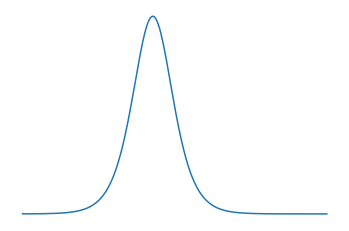

In [14]:
# Simulate 
p_t = 1000000
p_v = p_t
new_cases = [10]
active_cases = new_cases[0]
r = 0.001
x = 100
while p_v > 0 and active_cases >= 1:
    active_cases = np.sum(new_cases[-14:])
    data = {"active_cases": active_cases, "population": p_t, "vulnerable_pop": p_v}
    new_cases.append(transmissionModel(data, r, x))
    p_v -= new_cases[-1]

#Plot
plt.plot(new_cases)
plt.axis('off')
# title_obj = plt.title('High Transmission Low Exposure')
# plt.setp(title_obj, color='g')
plt.show()

For each month in each county, we calculate the values

In [15]:
# Group by month
combined_data_atl["month"] = combined_data_atl["date"].dt.strftime('%y-%m')

# Drill down to specific columns and drop na
model_data = combined_data_atl[["FIPS", "month", "new_cases","active_cases", "population", "vulnerable_pop"]].dropna()

#Groupby month and apply
model_fits = model_data.groupby(["FIPS", "month"]).apply(getTransmissionVariables)
model_fits.columns = ["x"]
model_fits = pd.DataFrame(model_fits.tolist(), index=model_fits.index, columns = ["transmission_chance", "exposure_rate"])

# Merge results back into combined data
modeled_data = combined_data_atl.merge(model_fits, on=["FIPS", "month"]).dropna()
modeled_data["modeled_new_cases"] = transmissionModel(modeled_data, modeled_data["transmission_chance"], modeled_data["exposure_rate"])
modeled_data.head()

,FIPS,date,Case_Count,mask_compliance,n_units,li_units,household_count,mean_income,population,n_units_per_household,...,new_cases,active_cases,vulnerable_pop,case_count_per_capita,new_cases_per_capita,mean_household_size,month,transmission_chance,exposure_rate,modeled_new_cases
319,13247,2020-03-01,0,0.773,288.0,180.0,32792.0,78651.0,90896.0,0.008783,...,0.0,2.842171e-13,90896.0,0.0,0.0,2.771896,20-03,0.034734,5.838598,0.0
320,13247,2020-03-02,0,0.773,288.0,180.0,32792.0,78651.0,90896.0,0.008783,...,0.0,2.842171e-13,90896.0,0.0,0.0,2.771896,20-03,0.034734,5.838598,0.0
321,13247,2020-03-03,0,0.773,288.0,180.0,32792.0,78651.0,90896.0,0.008783,...,0.0,2.842171e-13,90896.0,0.0,0.0,2.771896,20-03,0.034734,5.838598,0.0
322,13247,2020-03-04,0,0.773,288.0,180.0,32792.0,78651.0,90896.0,0.008783,...,0.0,2.842171e-13,90896.0,0.0,0.0,2.771896,20-03,0.034734,5.838598,0.0
323,13247,2020-03-05,0,0.773,288.0,180.0,32792.0,78651.0,90896.0,0.008783,...,0.0,2.842171e-13,90896.0,0.0,0.0,2.771896,20-03,0.034734,5.838598,0.0


We can see how close our fit was for Gwinett

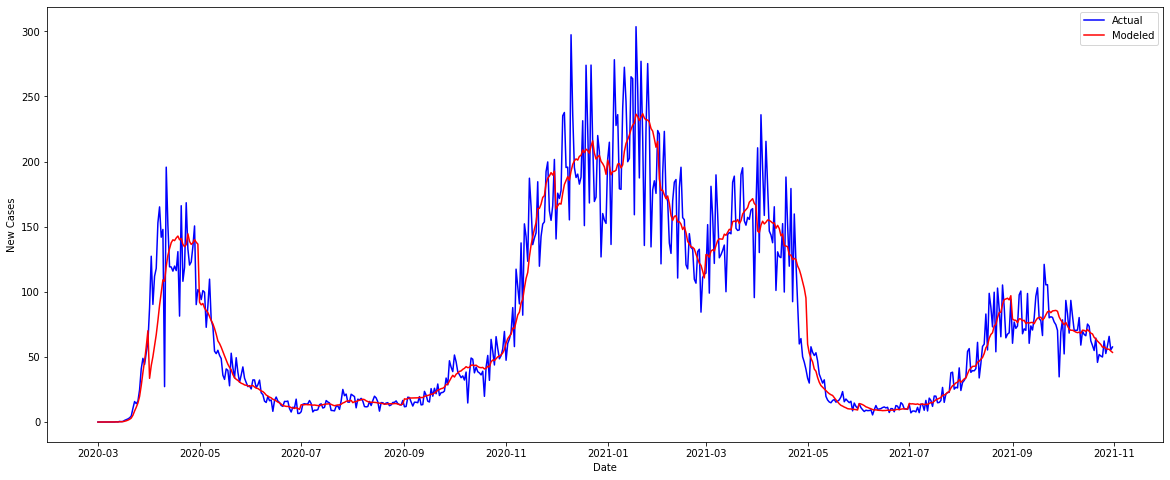

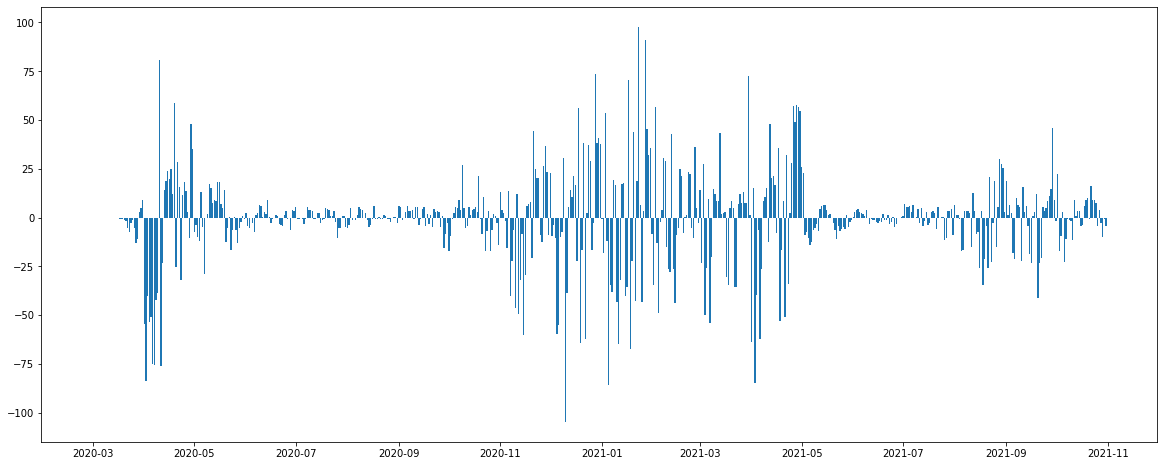

In [16]:
target_county = modeled_data[modeled_data["FIPS"] == '13135']
#target_county = modeled_data.groupby("date").sum().reset_index()

plt.figure(figsize=(20,8))
plt.plot(target_county["date"], target_county["new_cases"], 'b-', label='Actual')
plt.plot(target_county["date"], target_county["modeled_new_cases"], 'r-', label='Modeled')

plt.xlabel('Date')
plt.ylabel('New Cases')

plt.legend()
plt.show()

plt.figure(figsize=(20,8))
plt.bar(target_county["date"], target_county["modeled_new_cases"] - target_county["new_cases"], label='Errors')
plt.show()

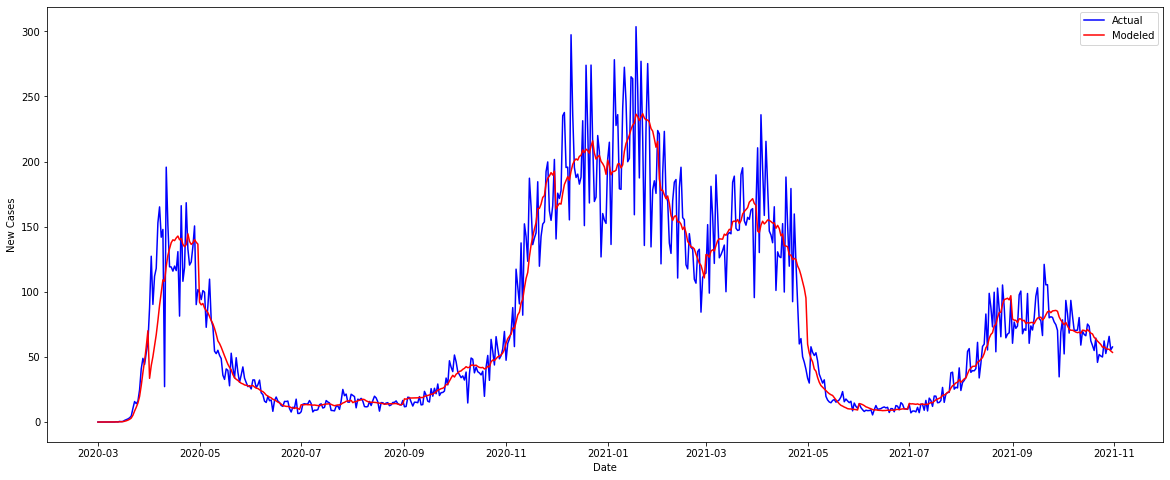

In [17]:
errors = modeled_data[modeled_data["FIPS"] == '13135']
#target_county = modeled_data.groupby("date").sum().reset_index()

plt.figure(figsize=(20,8))
plt.plot(target_county["date"], target_county["new_cases"], 'b-', label='Actual')
plt.plot(target_county["date"], target_county["modeled_new_cases"], 'r-', label='Modeled')

plt.xlabel('Date')
plt.ylabel('New Cases')

plt.legend()
plt.show()

And how parameters compared between Gwinnett and Atlanta Metro Area

In [18]:
import matplotlib.ticker as mtick

def compareParameters(model_data, target_fip, param_name):
    
    # Filter data
    target_county = model_data.loc[target_fip,:].reset_index()
    atl_area = model_data.groupby("month").mean().reset_index(0)
    xvals = atl_area.index

    # Create figure
    fig = plt.figure(figsize=(20,8))
    ax = fig.add_subplot(111)
    
    # Add bars
    w = 0.4
    ax.bar(xvals - w/2, target_county[param_name], width=w, label='Gwinnett')
    ax.bar(xvals + w/2, atl_area[param_name], width=w, label='Atlanta')

    # Label months
    plt.xlabel('Month')
    ax.set_xticks(xvals)
    ax.set_xticklabels(target_county["month"])

    # Label values
    if param_name == 'transmission_chance':
        plt.ylabel('Transmission Chance')
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, 1))
    else:
        plt.ylabel('Daily Exposures')

    plt.legend()
    plt.show()

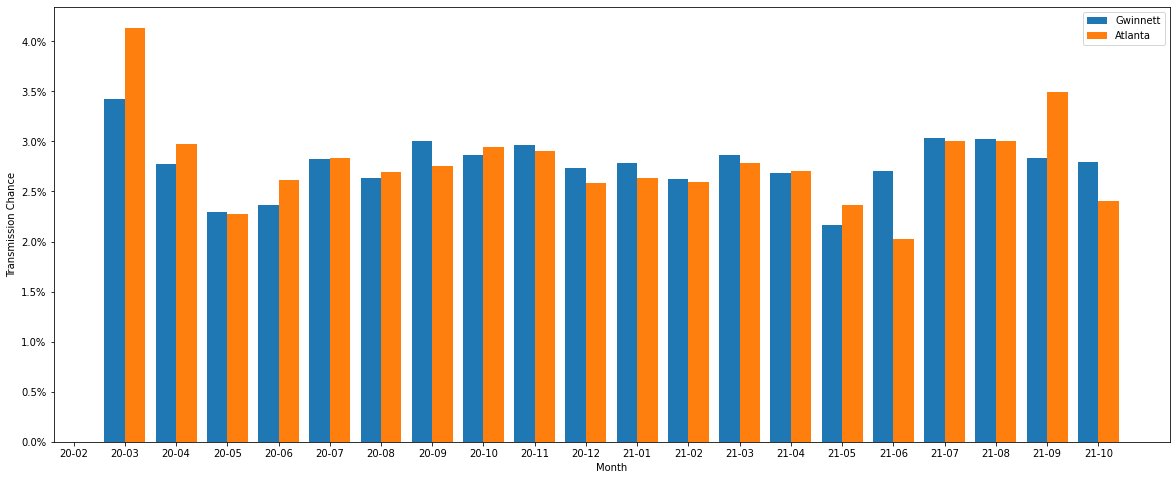

In [19]:
compareParameters(model_fits, '13135', 'transmission_chance')

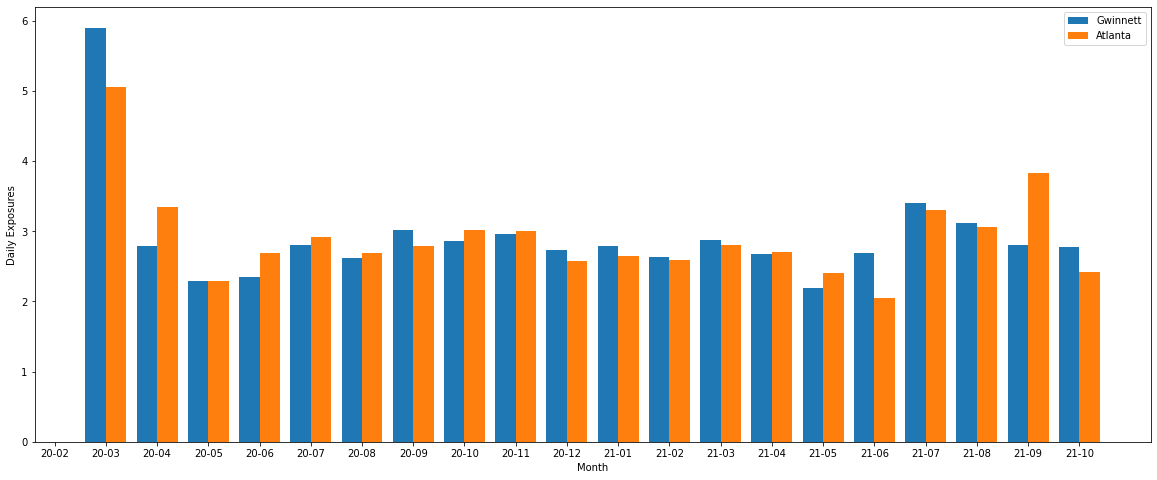

In [20]:
compareParameters(model_fits, '13135', 'exposure_rate')

In [21]:
model_fits.groupby("FIPS").mean() - model_fits.mean()

,transmission_chance,exposure_rate
FIPS,,
13057,0.000415,0.068434
13063,0.000283,-0.032550
13067,0.000228,0.053457
13089,-0.000600,-0.165272
13097,0.003037,0.056069
13113,-0.000788,0.062908
13117,-0.000603,0.035032
13121,-0.000376,-0.004611
13135,-0.000168,0.006288


In [22]:
modeled_data["new_cases_per_capita_diff"] =  modeled_data["new_cases_per_capita"] - modeled_data["new_cases_per_capita"].mean()
net_cases = modeled_data.groupby("FIPS")["Case_Count"].max().sum()
net_pop = modeled_data.groupby("FIPS")["population"].mean().sum()
pd.DataFrame({"new_cases": modeled_data.groupby("FIPS")["new_cases_per_capita_diff"].mean(),
             "case_count": modeled_data.groupby("FIPS")["case_count_per_capita"].max() - net_cases/net_pop,
             })


,new_cases,case_count
FIPS,,
13057,-0.000030,0.033118
13063,-0.000032,-0.001859
13067,-0.000039,0.007478
13089,-0.000044,-0.015762
13097,-0.000029,0.015878
13113,0.000039,-0.021174
13117,0.000008,0.002394
13121,-0.000002,-0.012225
13135,0.000036,0.005988


# Stage 4: ANALYSIS

We now analyze how our demogrpahic data relates to the modelled parameters

Each month is a data point

In [23]:
x_vars = ["mask_compliance", "li_units_per_household", "mean_household_size", "mean_income", "active_cases"]
y_vars = ["transmission_chance", "exposure_rate"]
monthly = modeled_data.groupby(["FIPS", "month"])[x_vars + y_vars].mean()
X = monthly[x_vars]
monthly

mask_compliance  li_units_per_household  mean_household_size  \
FIPS  month                                                                 
13057 20-03          0.80725                0.008294             2.769373   
      20-04          0.80725                0.008294             2.769373   
      20-05          0.80725                0.008294             2.769373   
      20-06          0.80725                0.008294             2.769373   
      20-07          0.80725                0.008294             2.769373   
...                      ...                     ...                  ...   
13247 21-06          0.77300                0.005489             2.771896   
      21-07          0.77300                0.005489             2.771896   
      21-08          0.77300                0.005489             2.771896   
      21-09          0.77300                0.005489             2.771896   
      21-10          0.77300                0.005489             2.771896   

             mean_income  active_cases  transmission_chance  exposure_rate  
FIPS  month                                                                 
13057 20-03     101950.0      0.114549             0.032735       5.732114  
      20-04     101950.0      4.278231             0.028814       2.856401  
      20-05     101950.0      7.685978             0.026270       2.526533  
      20-06     101950.0      5.507483             0.031815       2.942137  
      20-07     101950.0     18.071758             0.028166       2.839931  
...                  ...           ...                  ...            ...  
13247 21-06      78651.0      7.918367             0.026877       2.702507  
      21-07      78651.0      5.170507             0.028399       2.807945  
      21-08      78651.0     25.183015             0.030274       3.151457  
      21-09      78651.0     71.248299             0.030270       3.254802  
      21-10      78651.0    108.714286             0.027484       2.747453  

[220 rows x 7 columns]

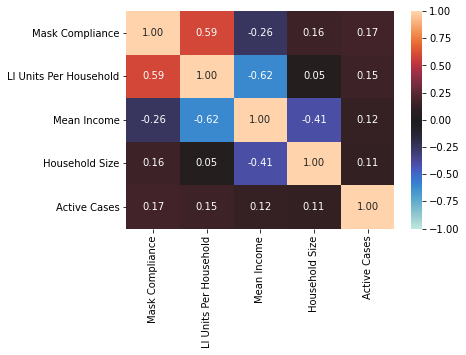

In [24]:
import seaborn as sn

df = X.copy()
df.columns = ["Mask Compliance", "LI Units Per Household", "Mean Income", "Household Size", "Active Cases"]
corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True, fmt='.2f', center=0, vmin = -1)
plt.show()

### Transmission Chance

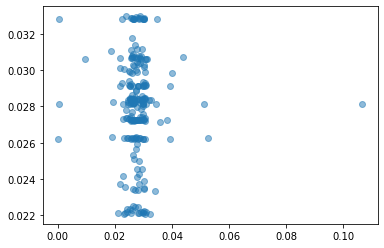

mask_compliance           0.069109
li_units_per_household    0.741890
mean_household_size       0.656222
mean_income               0.999998
active_cases              1.000036
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                  Generalized Linear Model Regression Results                  
===============================================================================
Dep. Variable:     transmission_chance   No. Observations:                  220
Model:                             GLM   Df Residuals:                      215
Model Family:                  Poisson   Df Model:                            4
Link Function:                     log   Scale:                          1.0000
Method:                           IRLS   Log-Likelihood:                -24.721
Date:                 Tue, 07 Dec 2021   Deviance:                      0.48831
Time:                         13:04:04   Pearson chi2:                    0.509
No. Iterations:                      4                                         
Covariance Type:                   HC3                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
mask_compliance           -2.6721      0.493     -5.422      0.000      -3.638      -1.706
li_units_per_household    -0.2986      2.390     -0.125      0.901      -4.982       4.385
mean_household_size       -0.4213      0.116     -3.634      0.000      -0.648      -0.194
mean_income            -2.319e-06   9.09e-07     -2.551      0.011    -4.1e-06   -5.37e-07
active_cases            3.607e-05   2.43e-05      1.482      0.138   -1.16e-05    8.38e-05
==========================================================================================
"""

In [29]:
import statsmodels.api as sm

y = monthly["transmission_chance"]
glm = sm.GLM(y, X, family=sm.families.Poisson())
results = binom_glm.fit(cov_type='HC3')

plt.plot(y, results.predict(X), 'o', alpha=0.5);
plt.show()

print(np.exp(results.params))

results.summary()


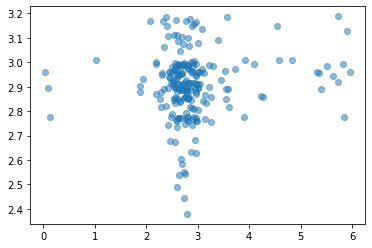

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          exposure_rate   R-squared (uncentered):                   0.926
Model:                            OLS   Adj. R-squared (uncentered):              0.925
Method:                 Least Squares   F-statistic:                              540.3
Date:                Tue, 07 Dec 2021   Prob (F-statistic):                   1.39e-119
Time:                        13:02:37   Log-Likelihood:                         -268.74
No. Observations:                 220   AIC:                                      547.5
Df Residuals:                     215   BIC:                                      564.4
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
mask_compliance            0.5241      1.648      0.318      0.751      -2.723       3.772
li_units_per_household     7.7419     11.045      0.701      0.484     -14.028      29.512
mean_household_size        0.7132      0.379      1.882      0.061      -0.034       1.460
mean_income             4.467e-06   2.98e-06      1.498      0.136   -1.41e-06    1.03e-05
active_cases              -0.0003      0.000     -2.109      0.036      -0.000   -1.68e-05
==============================================================================
Omnibus:                       74.073   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              324.308
Skew:                           1.270   Prob(JB):                     3.78e-71
Kurtosis:                       8.378   Cond. No.                     2.03e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.03e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [26]:
y = monthly["exposure_rate"]
lm = sm.OLS(y, X)
lm_results = lm.fit()
plt.plot(y, lm_results.predict(X), 'o', alpha=0.5);
plt.show()

lm_results.summary()

In [32]:
np.exp(results.params) * comparison_df["Diff"] / comparison_df["Atlanta"]


active_cases                   NaN
household_count                NaN
li_units                       NaN
li_units_per_household   -0.540503
mask_compliance           0.002040
mean_household_size       0.065755
mean_income              -0.062653
population                     NaN
dtype: float64

# Stage 5: REMODELING

We model how Gwinett might have looked if its demographics more closesly matched the rest of Atlanta.